In [ ]:
import cv2
import glob 
import pathlib
import os
import gc
import skimage
from skimage.transform import resize
from keras.constraints import max_norm
import tqdm
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101V2
import itertools
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv2D
from keras.layers import Conv3D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import AveragePooling1D
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import ConvLSTM1D
from keras.layers import Average
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as pyplot


# Metodi per la creazione della Resnet e LSTM

In [ ]:
def ResnetModel(input_layer):
  Resnet = keras.applications.Resnet101V2(include_top=False,weights='imagenet',input_shape=(75,175,3),pooling='avg') #pooling='avg'
  model = Sequential()
  model.add(input_layer)
  model.add(Resnet)
  return model

In [ ]:
def LSTM_Model(input_layer):
  from keras.layers.pooling import GlobalAveragePooling1D
  input_shape = (75, 175, 3)
  model = Sequential() 
  model.add(input_layer)
  model.add(Conv2D(3, (1, 1), input_shape = input_shape, activation = 'relu'))
  model.add(TimeDistributed(Flatten()))  
  model.add(LSTM(1024, return_sequences=True, dropout = 0.02, input_shape = (None,75,1024)))
  model.add(LSTM(512, return_sequences=True, dropout = 0.01, input_shape = (None,75,1024)))
  model.add(GlobalAveragePooling1D())
  model.build(input_shape=(1,75,175,3))
  return model

# Metodo di fusione dei modelli

In [ ]:
def FusionModel(model_resnet,model_lstm,num_classes):
  modelR = model_resnet
  modelL = model_lstm
  model = Sequential() 
  x = layers.Average()([modelR.output, modelL.output])
  x = Flatten()(x)
  out = Dense(num_classes, activation="softmax",kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(x)

  model = keras.Model([input_1, input_2], out)
  
  model.build((75,175,3))
  model.compile(loss="categorical_crossentropy", metrics=['accuracy', tf.keras.metrics.Precision(), 
                        tf.keras.metrics.Recall(),tf.keras.metrics.AUC()], optimizer='adam')
  
  return model

## Riduzione del dataset e definizione delle input shape del modello

In [ ]:
input_1 = keras.Input(shape=(75,175,3),name="input_layer_1")
print(input_1.shape)
input_2 = keras.Input(shape=(75,175,3),name="input_layer_2")
print(input_2.shape)
num_classes = 80

(None, 75, 175, 3)
(None, 75, 175, 3)


# Creazione del modello

In [ ]:
model_resnet = ResnetModel(input_1)
model_lstm = LSTM_Model(input_2)
model = FusionModel(model_resnet, model_lstm, num_classes)

2022-05-25 12:30:47.956395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 12:30:48.015448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 12:30:48.015645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 12:30:48.016123: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Lettura del dataset con split 70-15-15

In [ ]:
from PIL import Image
def create_training (base_dir, no_of_files_in_each_class,train_test_split):

  #Read all the folders in the directory
  folder_list = os.listdir(base_dir)
  print( len(folder_list), "categories found in the dataset")

  #Declare training array
  cat_list = []
  x = []
  y = []
  y_label = 0

  cat_list2 = []
  x_val = []
  y_val = []
  y_label_val = 0

  n_test_samples=int(no_of_files_in_each_class-(train_test_split*no_of_files_in_each_class))
  n_train_samples=no_of_files_in_each_class-n_test_samples
  



  #Using just 5 images per category
  for folder_name in tqdm.tqdm(folder_list):
      if folder_name != ".DS_Store":
        files_list = os.listdir(os.path.join(base_dir, folder_name))
        temp=[]
        temp2=[]
        i=0
        for file_name in files_list[:no_of_files_in_each_class]:
            if i>=n_train_samples:
              temp2.append(len(x_val))
              x_val.append(np.asarray(Image.open(os.path.join(base_dir, folder_name, file_name)).convert('RGB').resize((175, 75))))
              y_val.append(y_label_val)
              i+=1

            else:
              temp.append(len(x))
              x.append(np.asarray(Image.open(os.path.join(base_dir, folder_name, file_name)).convert('RGB').resize((175, 75))))
              y.append(y_label)
              i+=1


        
        y_label+=1
        cat_list.append(temp)
        y_label_val+=1
        cat_list2.append(temp2)


  cat_list = np.asarray(cat_list)
  x = np.asarray(x)/255.0
  y = np.asarray(y)
  cat_list2 = np.asarray(cat_list2)
  x_val = np.asarray(x_val)/255.0
  y_val = np.asarray(y_val)
  return x,y,x_val,y_val

base_dir = 'XM2VTS'

base_dir2 = base_dir
train_test_split = 0.7
no_of_files_in_each_class = 210
X,y,X_val,y_val=create_training(base_dir,no_of_files_in_each_class,0.7)
print('X, y shape',X.shape, y.shape) 
print(y)

80 categories found in the dataset


100%|███████████████████████████████████████████| 80/80 [00:37<00:00,  2.11it/s]
/run/user/1000/ipykernel_157385/2175794868.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cat_list2 = np.asarray(cat_list2)


X, y shape (11760, 75, 175, 3) (11760,)
[ 0  0  0 ... 79 79 79]


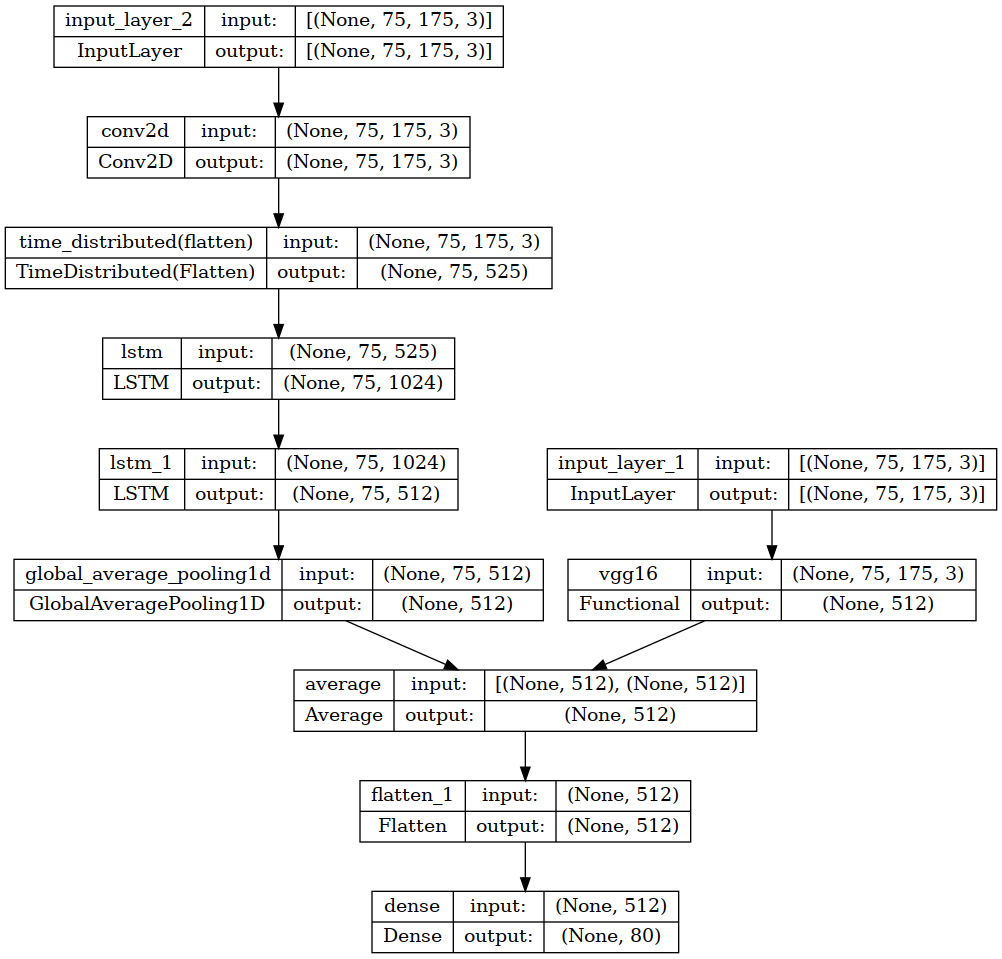

In [ ]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

# Conversione del dataset letto in tensori

In [ ]:
def onehotencode(labels):
  b = np.zeros((labels.size, labels.max()+1))
  b[np.arange(labels.size),labels] = 1
  return b


In [ ]:
gc.collect()
y2=onehotencode(y)
y_val=onehotencode(y_val)
gc.collect()
data_tensor = tf.convert_to_tensor(X)
lab_tensor = tf.convert_to_tensor(y2)
lab_tensor_val = tf.convert_to_tensor(y_val)
data_tensor_val = tf.convert_to_tensor(X_val)

ok
ok2
ok3
ok4


2022-05-25 12:31:30.732520: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3704400000 exceeds 10% of free system memory.
2022-05-25 12:31:32.100520: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1551060000 exceeds 10% of free system memory.


ok5


In [ ]:
data_tensor_test,data_tensor_val = tf.split(data_tensor_val,2) 
lab_tensor_test,lab_tensor_val = tf.split(lab_tensor_val,2)
gc.collect()

0

# Training del modello con cross-validation

In [ ]:
epochs=40
batch_size=64
steps_per_epoch = len(data_tensor)//batch_size

In [ ]:
history = model.fit(x = [data_tensor, data_tensor],
                    y=lab_tensor, 
                    validation_data=([data_tensor_val, data_tensor_val], lab_tensor_val), 
                    epochs = epochs, 
                    verbose = 1)

2022-05-25 12:31:32.744936: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3704400000 exceeds 10% of free system memory.


Epoch 1/40


2022-05-25 12:31:37.724393: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2022-05-25 12:31:40.639958: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


368/368 [==============================] - 60s 140ms/step - loss: 4.4277 - accuracy: 0.0108 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4960 - val_loss: 4.4076 - val_accuracy: 0.0187 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4744
Epoch 2/40
368/368 [==============================] - 46s 126ms/step - loss: 4.1008 - accuracy: 0.0437 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6859 - val_loss: 3.5122 - val_accuracy: 0.0715 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8448
Epoch 3/40
368/368 [==============================] - 46s 125ms/step - loss: 2.4072 - accuracy: 0.3762 - precision: 0.8249 - recall: 0.1435 - auc: 0.9301 - val_loss: 1.5114 - val_accuracy: 0.6097 - val_precision: 0.8704 - val_recall: 0.4582 - val_auc: 0.9623
Epoch 4/40
368/368 [==============================] - 46s 125ms/step - loss: 1.0498 - accuracy: 0.7428 - precision: 0.9091 - recall: 0.6389 - auc: 0.9761 - val_loss: 0.8431 - val_accuracy: 0.7977 - val_

In [ ]:
(loss, 
accuracy, precision, recall,auc) = model.evaluate([data_tensor_test, data_tensor_test], lab_tensor_test, verbose=1)

77/77 [==============================] - 3s 45ms/step - loss: 0.5424 - accuracy: 0.9025 - precision: 0.9215 - recall: 0.8964 - auc: 0.9818


# Plot dei risultati

In [ ]:
def plotAccuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('accuracy.png')
  plt.show()


def plotLoss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('loss.png')
  plt.show()

def plotPrecision(history):
  plt.plot(history.history['precision'])
  plt.plot(history.history['val_precision'])
  plt.title('model precision')
  plt.ylabel('precision')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('precision.png')  
  plt.show()

def plotRecall(history):
  plt.plot(history.history['recall'])
  plt.plot(history.history['val_recall'])
  plt.title('model recall')
  plt.ylabel('recall')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('recall.png')
  plt.show()


def getF1History(history,epochs):
    F1History = []
    F1History_val = []
    for i in range(epochs):
        recall = history.history['recall'][i]
        precision = history.history['precision'][i]
        recall_val = history.history['val_recall'][i]
        precision_val = history.history['val_precision'][i]
        F1History.append(2*((precision*recall)/(precision+recall+K.epsilon())))
        F1History_val.append(2*((precision_val*recall_val)/(precision_val+recall_val+K.epsilon())))
    return F1History,F1History_val 
    
def plotF1(f1,f1_val):
  plt.plot(f1)
  plt.plot(f1_val)
  plt.title('model F1 score')
  plt.ylabel('F1 score')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('F1.png')
  plt.show()


def plotAUC(history):
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model AUC')
  plt.ylabel('AUC')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('AUC.png')
  plt.show()



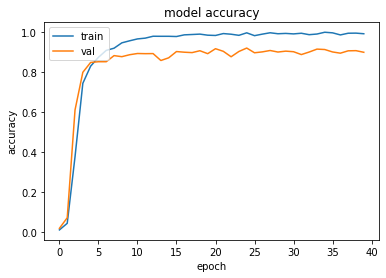

In [ ]:
plotAccuracy(history)

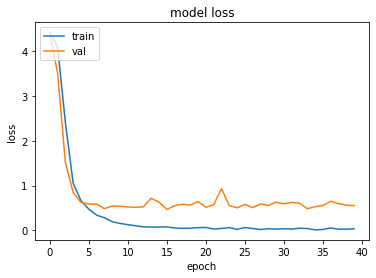

In [ ]:
plotLoss(history)

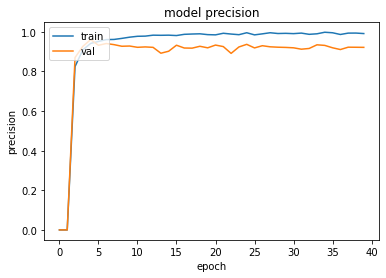

In [ ]:
plotPrecision(history)

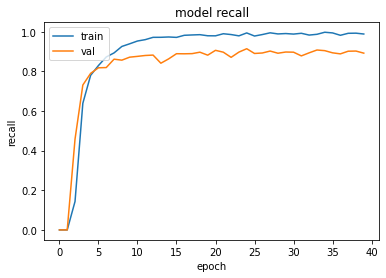

In [ ]:
plotRecall(history)

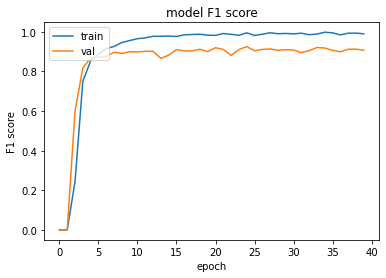

In [ ]:
from keras import backend as K
f1,f1_val = getF1History(history,epochs)
plotF1(f1,f1_val)

In [ ]:
from keras import backend as K
precision = 0.9215
recall = 0.8964
f1=2*((precision*recall)/(precision+recall+K.epsilon()))
print(f1)

0.9087766704011954


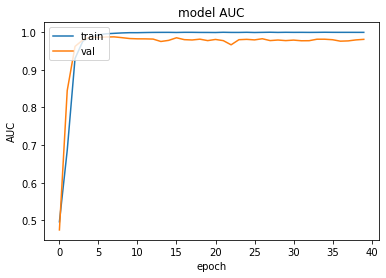

In [ ]:
plotAUC(history)